# CLEAN BUILD FROM SCRATCH EFFNET-UNET b7 on patches

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
from customeunet.utils import *
from customeunet.layers import *
from customeunet.efficientnet import *
from customeunet.efficientunet import *

# model

In [4]:
def AUXhead(in_channels, mid_channels, out_channels, upsample=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=upsample, mode='bilinear')
    )

In [5]:
class EfficientUnetAUX(nn.Module):
    def __init__(self, backbone, n_classes=2, concat_input=True):
        super().__init__()
        
        self.backbone = backbone
        
        self.encoder = EfficientNet.encoder(backbone, pretrained=True)
        self.model = EfficientUnet(self.encoder, out_channels=n_classes, concat_input=True)
        
        self.aux3head = AUXhead(128, 256, n_classes, 4)
        self.aux2head = AUXhead(256, 256, n_classes, 8)
        
    def forward(self, x):
        data = self.model(x)
        aux2 = self.aux2head(data['aux2'])
        aux3 = self.aux3head(data['aux3'])
        out = {
            'logits': data['x'],
            'aux2': aux2,
            'aux3': aux3,
        }
        return out

In [6]:
model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6)

In [7]:
inp = torch.randn(1, 3, 512, 512)

In [8]:
ot = model(inp)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [9]:
ot.keys()

dict_keys(['logits', 'aux2', 'aux3'])

In [10]:
ot['logits'].shape, ot['aux2'].shape, ot['aux3'].shape

(torch.Size([1, 6, 512, 512]),
 torch.Size([1, 6, 512, 512]),
 torch.Size([1, 6, 512, 512]))

# data

In [11]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

## data 512

In [12]:
# img256 = cv.imread('./../data/train_data_eunet_patches/256/train/10044_0000.png')
# img512 = cv.imread('./../data/train_data_eunet_patches/512/train/10044_0000.png')

In [13]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_data_eunet_patches/512/train/'
TRAIN_MASKS_DIR = './../data/train_data_eunet_patches/512/masks/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 512 # размер патча


In [14]:
train_df = pd.read_csv(TRAIN_CSV)

In [15]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [16]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [17]:
def make_512_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('/train/', '/masks/')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [18]:
train_df_512 = make_512_dataset(train_df)
print(train_df_512.shape)
train_df_512.head()

(2895, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
1,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
2,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
3,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
4,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4


In [19]:
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

In [20]:
train_transform= A.Compose([
    A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HueSaturationValue(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(0.05, 0.6),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=mean, std=std, 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [21]:
val_transform = A.Compose([
    A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=mean, std=std, 
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [22]:
class HubmapDataset512(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])

        data.update(upd_data)
        return data

In [23]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [24]:
train_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] == CURRENT_FOLD], val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE
torch.Size([3, 512, 512])
image values:  -3.1199498176574707 0.9707847237586975


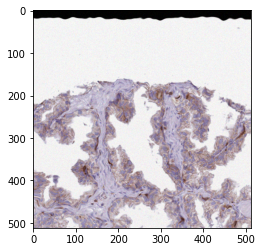

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


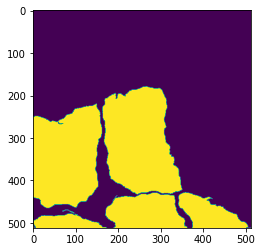

In [25]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)) * std + mean)
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [26]:
BATCH_SIZE = 6

In [27]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE
torch.Size([3, 512, 512])
image values:  -3.1199498176574707 0.9707847237586975


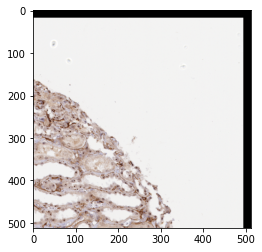

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


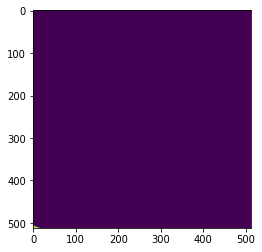

In [28]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)) * std + mean)
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# training

In [29]:
device = 'cuda:3'
DEVICE = device

In [30]:
model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6).to(device)

In [31]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

77928738

In [32]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 800; sustain_epochs = 200; exp_decay = .9999    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = max((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs)* (0.8+0.03*np.sin(epoch / 100)), 0) + min_lr
        return lr
 
    return lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

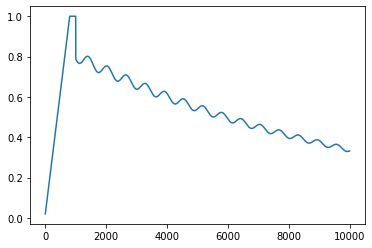

In [33]:
xxx = []
for i in range(10000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.show()

# valid code

In [34]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

In [35]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [36]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [37]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        out = self.model(x)
        prob = F.softmax(out['logits'], dim=1)
        return prob

In [55]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4, threshold=0.5):
    THRESHOLD = threshold
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    gt_mask  = np.load('./../data/train_masks/{}.npy'.format(id))
#     gt_mask  = cv.imread('./../data/train_masks/{}.npy'.format(id), cv.IMREAD_GRAYSCALE)
    
    gt_mask = gt_mask / max(gt_mask.max(), 1)
    
    scale_factor = 0.5 * (pixel_size / 0.4)
    image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
#     image_rot = image.copy()
    masks = []
    for _ in range(1):
#         image_rot = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
        
        image_tensor = val_transform(image=image)['image']

        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            infer_result = sliding_window_inference(
                image_tensor, roi_size=(512, 512), sw_batch_size=2, predictor=predictor, 
                overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
                padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
            )

        organ_id = ORGAN2ID[organ] + 1
        pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
        masks.append(pr_mask)
        
    pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
#     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)
    pr_mask = cv.resize(pr_mask, gt_mask.shape, cv.INTER_NEAREST)
    
    return pr_mask, gt_mask

In [56]:
def validate(val_df, model, threshold=0.5):
    predictor = Predictor(model)
    
    dices = []
    
    by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_mask, gt_mask = infer_id(predictor, id, organ=organ, pixel_size=pixel_size, threshold=threshold)
        dice = dice_coef2(gt_mask, pred_mask)
        dices.append(dice)
        by_organ_dice[organ].append(dice)
    new_record = dict()
    new_record['dices'] = dices
    new_record['by_organ'] = by_organ_dice
    return new_record

# criterion

In [40]:

# def criterion(predicts,masks):
#     return 0.5 * bce_loss(predicts, masks) + 0.5 * dice_loss(predicts, masks)

# 45 epochs was CE loss for logit, aux2, aux3
# loss = 1.0 * loss_pred + 0.4 * loss_aux3 + 0.02 * loss_aux2 
ce_loss = nn.CrossEntropyLoss().to(device)

# criterion = ce_loss

In [41]:
import segmentation_models_pytorch as smp

In [42]:
# 45 epoch - 60 epoch

criterion_aux = ce_loss

criterion_tversky = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=0.0, ignore_index=None, 
    eps=1e-07, alpha=0.5, beta=0.5, gamma=1.0
)

def criterion_image(predicts,masks):
    return 1.0 * ce_loss(predicts, masks) #+ 0.8 * criterion_tversky(predicts, masks)

In [43]:
# # from 60 epoch

# criterion_aux = ce_loss

# criterion_tversky = smp.losses.TverskyLoss(
#     mode='multiclass', classes=None, log_loss=False, 
#     from_logits=True, smooth=1e-6, ignore_index=None, 
#     eps=1e-07, alpha=0.5, beta=0.5, gamma=1
# )

# def criterion_image(predicts,masks):
#     return 0.5 * ce_loss(predicts, masks) + 0.5 * criterion_tversky(predicts, masks)

In [44]:
learning_rate = 1e-3 / 5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)

In [45]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

In [46]:
train_loss = []
accuracy = [] 
lr_hist = []

In [47]:
logfile = open('log.train.txt', mode='a')
logfile.write('\n--- [START %s] %s\n\n' % ('Effnet-unet-b7', '-' * 64))

94

In [48]:
def log(string):
    print(string)
    logfile.write(string + '\n')

In [49]:
# !mkdir checkpoint_fold_1

In [50]:
N_EPOCHS = 500
global_it = 0
VIRTUAL_BATCH_SIZE = 3

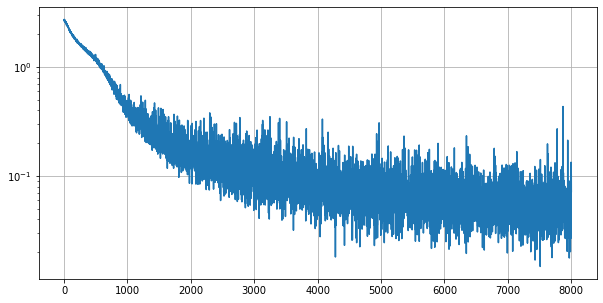

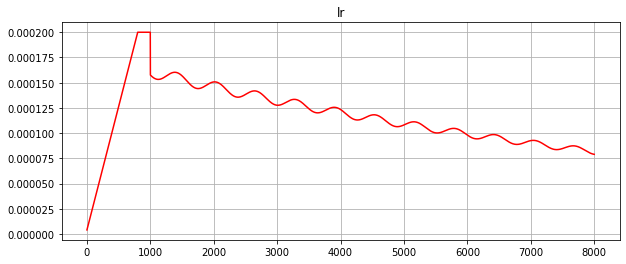

==> Epoch 64 (007/385) | loss: 0.06373
==> Epoch 64 (022/385) | loss: 0.03036
==> Epoch 64 (037/385) | loss: 0.02632
==> Epoch 64 (052/385) | loss: 0.02649


In [ ]:
for epoch in range(1, N_EPOCHS):
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
        
        images = batch['image'].to(device, dtype=torch.float)
        masks = batch['mask'].to(device, dtype=torch.long)

        pred = model(images)
        loss_pred = criterion_image(pred['logits'], masks)
        
        loss_aux3 = criterion_aux(pred['aux3'], masks)
        loss_aux2 = criterion_aux(pred['aux2'], masks)
        
        loss = 1.0 * loss_pred + 0.2 * loss_aux3 + 0.01 * loss_aux2 
        
        loss.backward()
                 
        batch_train_loss.append(loss.item())
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 5) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch + 1, iteration, len(loader_train), loss.item()))

        
            
        if iteration % (VIRTUAL_BATCH_SIZE * 40) == 0:
            clear_output()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    # val -------------------------------
    if epoch % 1 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                './checkpoint_fold_{}'.format(CURRENT_FOLD), 
                'effnetb5_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 
            logfile.flush()

In [ ]:
# pred['logits'].shape

In [ ]:
# masks.shape

In [ ]:
masks

In [57]:
model.eval()

with torch.no_grad():
    val_res = validate(val_df_id, model)
    val_dice = np.mean(val_res['dices'])
    log('DICE: {}'.format(val_dice))
    for key, value in val_res['by_organ'].items():
        log('{:20}: {:6.5f}'.format(key, np.mean(value)))

    torch.save(model.state_dict(), os.path.join(
        './checkpoint_fold_{}'.format(CURRENT_FOLD), 
        'effnetb5_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
    )) 
    logfile.flush()

  0%|          | 0/70 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 70/70 [00:21<00:00,  3.31it/s]


DICE: 0.0004540329154448957
kidney              : 0.00000
prostate            : 0.00045
largeintestine      : 0.00195
spleen              : 0.00003
lung                : 0.00000
